In [35]:
import os
import shutil
import cv2 as cv
import numpy as np
from tqdm.notebook import tqdm
import rasterio
import matplotlib.pyplot as plt

In [45]:
def merge_tiffs(data_dir):
    os.makedirs(os.path.join(data_dir, "images_merge"), exist_ok=True)

    tiff_files_li=[]
    for ti in os.listdir(os.path.join(data_dir, "images/")):
        if '.tif' in ti:
            tiff_files_li.append(ti)
        else:
            shutil.copy(os.path.join(data_dir, "images/", ti), os.path.join(data_dir, "images_merge/", ti))
    
    for filename in tqdm(tiff_files_li):
        infile1 = os.path.join(data_dir,"images/",filename)
        infile2 = os.path.join(data_dir,"images2/",filename)
        outfile = os.path.join(data_dir,"images_merge/",filename)
        with rasterio.open(infile1) as dataset:
            data1 = dataset.read()[0:3,:,:]
            crs1 = dataset.crs
            dtype1 = data1.dtype
        with rasterio.open(infile2) as dataset:
            data2 = dataset.read()
            crs2 = dataset.crs
            dtype2 = data2.dtype
        assert data1.shape[-2:] == data2.shape[-2:]
        assert crs1 == crs2
        if not dtype1 == dtype2:
            print(f"Casting {dtype2} to {dtype1}")
            data2 = data2.astype(dtype1)

        # print(data1.shape, data2.shape)
        with rasterio.open(
            outfile,
            'w',
            driver='GTiff',
            count=data1.shape[0] + data2.shape[0],
            height=data1.shape[1],
            width=data1.shape[2],
            dtype=data1.dtype,
            crs=crs1,
            compress='lzw',
            GEOTIFF_PREDICTOR=2
            ) as new_dataset:
            # print("Output Shape:", new_dataset.shape)
            new_dataset.write(np.concatenate([data1, data2], axis=0))

In [57]:
data_dir = "../data/Image_Chips_128_overlap_balanced_dem/"

In [58]:
merge_tiffs(data_dir)

  0%|          | 0/640 [00:00<?, ?it/s]

/home/philip/miniconda3/envs/unet-ortho/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [59]:
testfile = None
for ti in os.listdir(os.path.join(data_dir, "images/")):
        if '.tif' in ti:
            testfile = ti
            break
testfile

'000000038400.tif'

In [60]:
image1 = cv.imread(os.path.join(data_dir, "images/", testfile), cv.IMREAD_UNCHANGED)
image1.shape

(128, 128, 4)

In [61]:
image2 = cv.imread(os.path.join(data_dir, "images2/", testfile), cv.IMREAD_GRAYSCALE | cv.IMREAD_ANYDEPTH)[:,:,None]
image2.shape

(128, 128, 1)

In [62]:
image3 = cv.imread(os.path.join(data_dir, "images_merge/", testfile), cv.IMREAD_UNCHANGED | cv.IMREAD_ANYDEPTH)
image3.shape

(128, 128, 4)

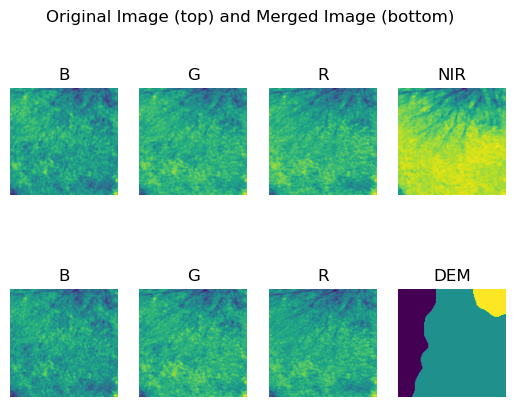

In [63]:
fig, axs = plt.subplots(2, 4)
fig.suptitle("Original Image (top) and Merged Image (bottom)")
bands1 = ["B", "G", "R", "NIR"]
bands2 = ["B", "G", "R", "DEM"]
for i in range(4):
    axs[0, i].imshow(image1[:,:,i])
    axs[0, i].set_title(bands1[i])
    axs[0, i].set_axis_off()
    axs[1, i].imshow(image3[:,:,i])
    axs[1, i].set_title(bands2[i])
    axs[1, i].set_axis_off()